## Part 4 — Occlusion (Foreground Masking)

This notebook is a **clean, reader-friendly** walkthrough of **Part 4**.

Aligned with the real project code:
- Parameters: `config.py` → `Part4Config`, `Part1Config`
- Tracking + pose: `tracker.py` → `PlanarTracker` + `cv2.solvePnP`
- Mesh rendering: `ar_render.py` → `load_mesh_trimesh`, `transform_mesh_to_plane`, `draw_mesh_flat`
- Occlusion mask + compositing: `occlusion.py` → `raw_hsv_mask`, `clean_binary_mask`, `dilate_mask`, `composite_occlusion`

### Goal
Render the AR object, then **composite** it so that the detected foreground (hand) correctly occludes the AR.

---

### Setup
Run from inside the `augmented-reality-planar/` folder so relative `data/...` paths resolve.


In [27]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

from config import Part1Config, Part4Config
from camera import load_calibration_npz
from tracker import PlanarTracker
from ar_render import load_mesh_trimesh, transform_mesh_to_plane, draw_mesh_flat, scale_K_to_new_size, make_plane_object_points
from occlusion import raw_hsv_mask, clean_binary_mask, dilate_mask, composite_occlusion

ROOT = Path().resolve()
cfg4 = Part4Config()
tracker_cfg = Part1Config()

calib = load_calibration_npz(str(ROOT / cfg4.calib_output_path))
print("calibration image_size:", calib.image_size)
print("video:", cfg4.video_path)
print("reference:", cfg4.reference_path)
print("model:", cfg4.model_path)


calibration image_size: (4284, 5712)
video: data/part4_occlusion_hand.mp4
reference: data/part4_reference.JPG
model: data/models/86jfmjiufzv2.obj


### Step 1 — Load inputs (reference, one video frame) and camera parameters

We use one frame for clarity.

We also build `K`/`dist` for the video resolution (scale `K` if needed), same as in `main.py`.


(1080, 1920)

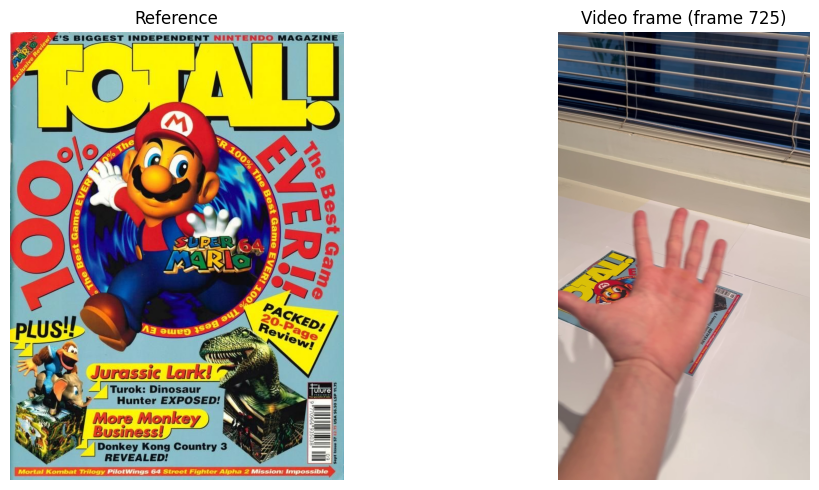

In [28]:
ref_path = ROOT / cfg4.reference_path
video_path = ROOT / cfg4.video_path
model_path = ROOT / cfg4.model_path

# Choose which frame to analyze
frame_idx = 725 # change this (e.g., 120, 250, ...)

ref_bgr = cv2.imread(str(ref_path))
assert ref_bgr is not None, f"Could not read reference: {ref_path}"

cap = cv2.VideoCapture(str(video_path))
assert cap.isOpened(), f"Could not open video: {video_path}"

out_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
out_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_idx))
ok, frame_bgr = cap.read()
cap.release()
assert ok and frame_bgr is not None, f"Could not read frame {frame_idx}"

K_calib = np.asarray(calib.K, dtype=np.float64).reshape(3, 3)
dist = np.asarray(calib.dist, dtype=np.float64).reshape(-1, 1)
K = K_calib
if tuple(calib.image_size) != (out_w, out_h):
    K = scale_K_to_new_size(K_calib, tuple(calib.image_size), (out_w, out_h))
K = np.asarray(K, dtype=np.float64).reshape(3, 3)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(cv2.cvtColor(ref_bgr, cv2.COLOR_BGR2RGB))
ax[0].set_title("Reference")
ax[1].imshow(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
ax[1].set_title(f"Video frame (frame {frame_idx})")
for a in ax:
    a.axis("off")
plt.tight_layout()

(out_w, out_h)


### Step 2 — Render the AR object (mesh) on this frame

We first render the AR mesh (same as Part 3 style), producing an `ar_frame`.

Then we will use the occlusion mask to composite `frame` vs `ar_frame`.


tracking dbg: {'good': 95, 'inliers': 40, 'held': 0, 'smoothed': 0}
pose ok? True


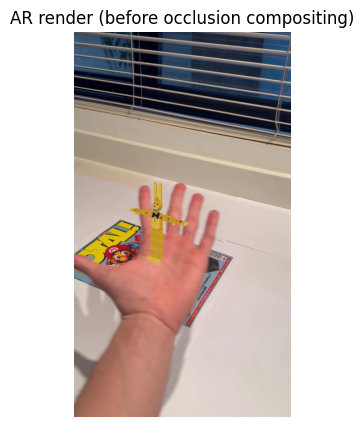

In [29]:
# Plane object points (Z=0), same as main.py Part 4
ref_h, ref_w = ref_bgr.shape[:2]
ref_aspect = ref_h / float(ref_w)
plane_w = float(cfg4.plane_width)
plane_h = float(cfg4.plane_width) * ref_aspect
obj_plane = np.ascontiguousarray(make_plane_object_points(plane_w, plane_h), dtype=np.float64).reshape(-1, 3)

# Load + place mesh on the plane
assert model_path.exists(), f"Model not found: {model_path}"
v, f, face_colors = load_mesh_trimesh(str(model_path))

v_plane = transform_mesh_to_plane(
    v,
    plane_w=plane_w,
    plane_h=plane_h,
    scale_frac=cfg4.model_scale_frac,
    offset_x_frac=cfg4.model_offset_x_frac,
    offset_y_frac=cfg4.model_offset_y_frac,
    z_up=True,
    rotate_x_deg=cfg4.rotate_x_deg,
    rotate_y_deg=cfg4.rotate_y_deg,
    rotate_z_deg=cfg4.rotate_z_deg,
)

# Track + pose
tracker = PlanarTracker(ref_bgr, tracker_cfg)
H, corners, dbg = tracker.track(frame_bgr)
print("tracking dbg:", dbg)

ar_frame = frame_bgr.copy()
ok_pose = False

if corners is not None:
    img_pts = np.asarray(corners, dtype=np.float64).reshape(-1, 2)
    if img_pts.shape == (4, 2) and np.isfinite(img_pts).all():
        ok_pnp = False
        try:
            # Part 4 config chooses IPPE vs ITERATIVE
            flag = int(cv2.SOLVEPNP_IPPE) if (str(cfg4.pnp_variant).strip().upper() == "IPPE" and hasattr(cv2, "SOLVEPNP_IPPE")) else int(cv2.SOLVEPNP_ITERATIVE)
            ok_pnp, rvec, tvec = cv2.solvePnP(obj_plane, img_pts, K, dist, flags=flag)
        except cv2.error:
            ok_pnp = False

        if ok_pnp:
            ok_pose = True
            proj, _ = cv2.projectPoints(v_plane, rvec, tvec, K, dist)
            verts2d = proj.reshape(-1, 2)

            # Painter order (far -> near) like main.py
            R, _ = cv2.Rodrigues(rvec)
            cam = (R @ v_plane.T + tvec).T
            z = cam[:, 2]
            face_depth = z[f].mean(axis=1)
            order = np.argsort(face_depth)[::-1]

            ar_frame = draw_mesh_flat(ar_frame, verts2d, f, face_colors, order=order)

print("pose ok?", ok_pose)

plt.figure(figsize=(8, 5))
plt.imshow(cv2.cvtColor(ar_frame, cv2.COLOR_BGR2RGB))
plt.title("AR render (before occlusion compositing)")
plt.axis("off")
plt.show()


### Step 3 — Foreground (hand) mask

We reproduce the mask pipeline from `occlusion.py`:
- HSV threshold → `raw_hsv_mask`
- cleanup (median + open + close) → `clean_binary_mask`
- optional dilation → `dilate_mask`


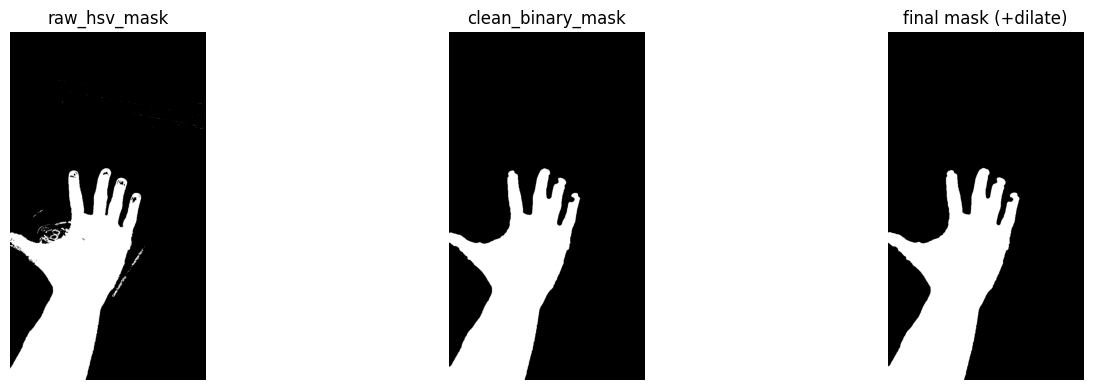

In [30]:
mask_raw = raw_hsv_mask(
    frame_bgr,
    h_min=int(cfg4.h_min),
    h_max=int(cfg4.h_max),
    s_min=int(cfg4.s_min),
    s_max=int(cfg4.s_max),
    v_min=int(cfg4.v_min),
    v_max=int(cfg4.v_max),
)

mask_clean = clean_binary_mask(
    mask_raw,
    use_median=bool(cfg4.use_median),
    median_ksize=int(cfg4.median_ksize),
    use_morph=bool(cfg4.use_morph),
    open_ksize=int(cfg4.open_ksize),
    close_ksize=int(cfg4.close_ksize),
    iters=int(cfg4.iters),
)

mask_final = mask_clean
if bool(cfg4.use_dilate):
    mask_final = dilate_mask(mask_final, ksize=int(cfg4.dilate_ksize), iters=int(cfg4.dilate_iters))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].imshow(mask_raw, cmap="gray")
ax[0].set_title("raw_hsv_mask")
ax[1].imshow(mask_clean, cmap="gray")
ax[1].set_title("clean_binary_mask")
ax[2].imshow(mask_final, cmap="gray")
ax[2].set_title("final mask (+dilate)")
for a in ax:
    a.axis("off")
plt.tight_layout()


### Step 4 — Composite (occlusion)

Final output rule (same as `composite_occlusion()`):
- where `mask == 255`: keep the real frame (foreground occludes AR)
- where `mask == 0`: show the AR render


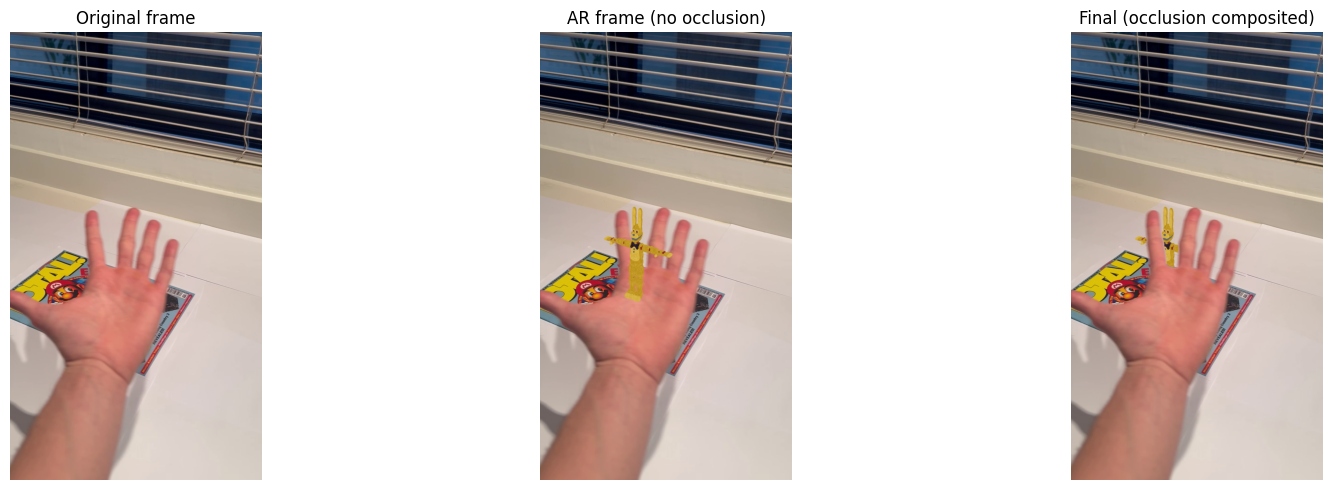

In [31]:
out = composite_occlusion(frame_bgr, ar_frame, mask_final)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].imshow(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original frame")
ax[1].imshow(cv2.cvtColor(ar_frame, cv2.COLOR_BGR2RGB))
ax[1].set_title("AR frame (no occlusion)")
ax[2].imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
ax[2].set_title("Final (occlusion composited)")
for a in ax:
    a.axis("off")
plt.tight_layout()
